In [9]:
import usb.core
import usb.util
from fx2 import FX2Config,FX2Device

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import struct
import numpy as np

In [10]:
import json
import base64

with open('config.json') as json_file:
    payloads = json.load(json_file)
for k in payloads.keys():
    payloads[k] = base64.b64decode(payloads[k][1:-1])

In [11]:
ARRAY = b'\x00'
for k in range(64):
    ARRAY += b'\x00' 


def InitDevice():
    dev = usb.core.find(idVendor=0x04B4, idProduct=0x8613)

    if not dev: print("No Device")

    c = 1
    for config in dev:
        #print('config', c)
        #print('Interfaces', config.bNumInterfaces)
        # The device was getting "Err 16 busy" on my ubuntu
        for i in range(config.bNumInterfaces):
            if dev.is_kernel_driver_active(i):
                dev.detach_kernel_driver(i)
            #print(i)
        c+=1

        #print(dev)
    try:
        dev.set_configuration()
    except:
        print("Deja fait")

    conf = FX2Config()
    device = FX2Device()
    device.timeout
    return device
    
def BulkOut(device,payload):
    # 
    return device.bulk_write(0x02, payload,timeout=None)

def BulkIn(device,Length):
    # Receive from Bulk
    return device.bulk_read(0x86,Length)
            
def ControlIn(device):
    return device.control_read(0x40, 184, 0, 0, 32,timeout=None)

def ControlOut(device,request,value,index,length):
    return device.control_write( 0x40, request, value, index,ARRAY[:length],timeout=None )

## Inits

def InitOneA(device,TwoBytes): #178 1 to 179 2
    ControlOut(device,178,1,0,16)
    BulkOut(device,TwoBytes)
    ControlOut(device,179,2,0,16)
    return BulkIn(device,512)

def Read512(device):
    ControlOut(device,179,1,0,16)
    return struct.unpack( '<512B', BulkIn(device,512) )

def BulkOutTwo(device,Two):
    ControlOut(device,178,1,0,16)
    BulkOut(device,Two)

def BulkOutTwo512(device,Two):
    ControlOut(device,178,1,0,16)
    BulkOut(device,Two)
    return Read512(device) 

def BulkOutFour(device,Four):
    ControlOut(device,178,2,0,16)
    BulkOut(device,Four)
    
def BulkOutLarge(device,Large):
    ControlOut(device,178,2,0,16)
    if len(Large)<=4096:
        BulkOut(device,Large)
    else:
        NPackets = len(Large)//4096 
        for k in range(NPackets+1):
            if len(Large[4096*k:]) >= 4096:
                #print(k,len(Large[4096*k:4096*(k+1)]))
                BulkOut(device,Large[4096*k:4096*(k+1)])
            else:
                if len(Large[4096*k:]):
                    #print(k,len(Large[4096*k:]))
                    BulkOut(device,Large[4096*k:])
        
def readWrite(device,command):
    # Used to write something somewhere, and check if the reply is identical 
    BulkOutTwo(device,command) 
    return BulkOutTwo512(device,b'\xff'+command[0:1])

def Init1004(device,FourBytes):
    BulkOutTwo(device,b'\x10\x04')
    BulkOutFour(device,FourBytes)
    return 1

## Init facility
    
def InitOn(device):                # 
    ControlIn(device)              # Checks name of the probe
    InitOneA(device,b'\x10\x0e')   # 
    ControlOut(device,179,2,0,16)
    ControlIn(device)              # Checks name of the probe
    BulkOutTwo(device,b'\xff\x06')   # 113 to 119
    
def InitSeries10(device):               
    # What would we have here ?
    for k in [b'\x01\x00\x00\x0f',
              b' \x00\x03\x0f',
              b'\x00\x00\x03\x0f'
              b'\xe3\x00\x16\x0f', 
              b'\xff\x00\x14\x0f',
              b'\xc5\x80B\x0f',
              b'\x0c\x82F\x0f']:
        Init1004(device,k)
    
def InitArrays(device):                      # Starting with TGC
    
    # Array setup ?
    BulkOutTwo(device,b'\x10\x00')         # Command n255
    BulkOutLarge(device,payloads["259"])   # 960-element array. 6*160. Delays ?
    
    BulkOutTwo(device,b'\x10\x05')
    BulkOutLarge(device,payloads["279"])   # 16k pts
    
    BulkOutTwo(device,b'\x10\x06')
    BulkOutLarge(device,payloads["293"])   # 16k pts
    
    BulkOutTwo(device,b'\x10\x03')
    BulkOutLarge(device,payloads["307"])   # *Array 307
    
    BulkOutTwo(device,b'\x10\x0c')
    BulkOutLarge(device,payloads["315"])   # *Array 315-321
    
    BulkOutTwo(device,b'\x10\n')
    BulkOutLarge(device,payloads["329"])   # *Array 329

    BulkOutTwo(device,b'\x10\t')
    BulkOutLarge(device,payloads["337"])   # 337 to 357

    # ATGC
    BulkOutTwo(device,b'\x10\x07')
    BulkOutLarge(device,payloads["365"])   # Values match the ATGC values

    # DTGC
    BulkOutTwo(device,b'\x10\x08')
    BulkOutLarge(device,payloads["373"])   # Values match the dTGC values, up to a facteur 16
    
    BulkOutTwo(device,b'\x10\x08')         # Why we we do b 1008 twice ? ??
    BulkOutLarge(device,payloads["393"])   # 

    
def InitRegisters(device) :

    # Should guess what we have here
    readWrite(device,b'\x1b\x00') 
    readWrite(device,b'#\xe0') 
    readWrite(device,b'$\x01') 
    readWrite(device,b'%\xdf') 
    readWrite(device,b'&\x01')                
    readWrite(device,b' \x04') 
    readWrite(device,b'\x1a\x06')  
    readWrite(device,b'+\xe9') 
    readWrite(device,b',\t') 
    readWrite(device,b'\x17\x01') 
    readWrite(device,b"'\x19")
    readWrite(device,b'(\x00')
    readWrite(device,b')|')  
    readWrite(device,b'*\x01')   
    readWrite(device,b'\x18\x01') 
    readWrite(device,b'@\x0b') 
    readWrite(device,b'A\x01') 
    readWrite(device,b'\x12\x01') 
    readWrite(device,b'\xfe\xaa')  
        
    ControlOut(device,182,0,0,16) ## 182, packet ID 515
    
# Image acquisition

def freeze(device):
    readWrite(device,b'\x11\x01') 

def unfreeze(device):
    readWrite(device,b'\x11\x00')
    ControlOut(device,179,0,0,16) # Seems to start: without it, no acqs

def getImages(device,n=1):
    IMG = DLImgs(device,n)
    NPts =np.shape(IMG)[0]*np.shape(IMG)[1]
    IMG = np.array( IMG, dtype=np.int )
    IMG = IMG.reshape((NPts//160, 160))
    images = []
    for k in range(n):
        images.append(IMG[512*k:512*(k+1)] )
    return images

def DLImgs(device,n=1):
    IMG = []
    unfreeze(device)
    for k in range(n*40):
        tple = struct.unpack( '<2048H', device.bulk_read(0x86,4096) ) 
        my_array = np.array( tple, dtype=np.int )
        IMG.append(my_array)
    freeze(device)
    return IMG


## Facility 
def checkAddress(device,address): 
    return [x for x in BulkOutTwo512(device, b'\xff'+address)][1:2]

## Starting the probe
def Start():
    device = InitDevice()
    InitOn(device)
    InitSeries10(device)
    InitArrays(device)
    InitRegisters(device)
    return device

# Testing if acq works

In [12]:
device = Start()

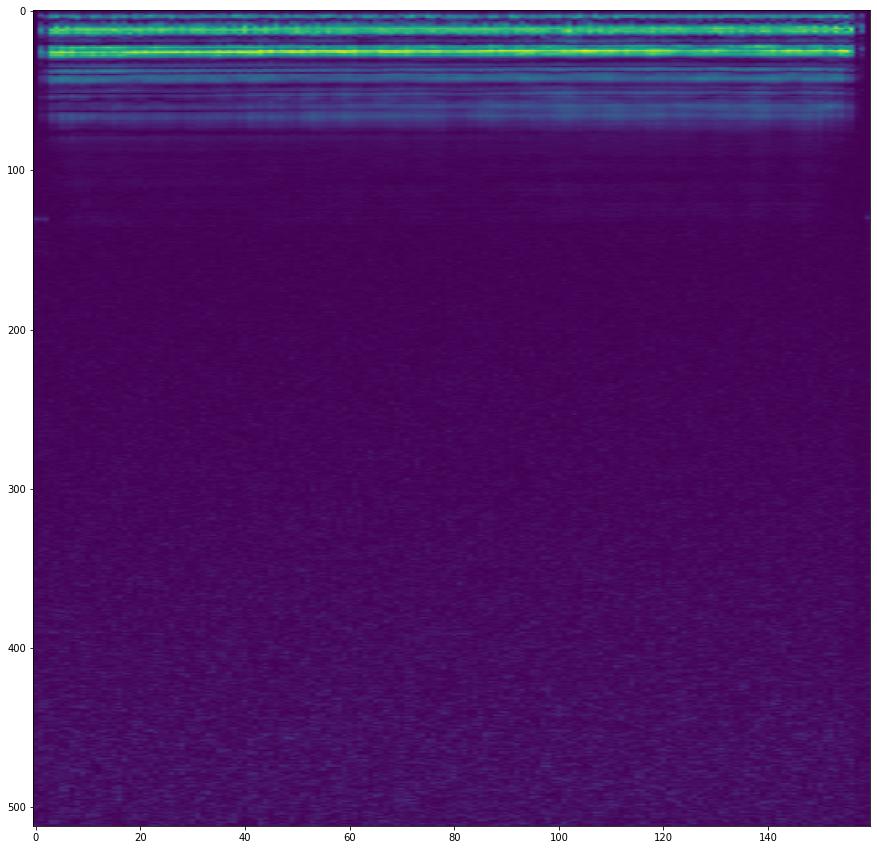

In [13]:
acq = getImages(device,n=3)
plt.figure(figsize=(15,15))
plt.imshow(acq[1], aspect='auto')

In [14]:
acq = getImages(device,n=3)

# Exploring readable registers

In [17]:
HEADER = "Unit"
for k in range(16):
    HEADER+= " "+str(k).rjust(4, ' ')
print(HEADER)
for k in range(16):
    LIGNE = str(k).rjust(4, ' ')
    for j in range(16):
        RES = checkAddress(device,bytearray([16*k+j]))[0]
        LIGNE+= " "+str(RES).rjust(4, ' ')
    print(LIGNE)

Unit    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
   0   19    6    5   10    0    8   72   83   83   83   83   83   83   83    0    0
   1    8    1    1    1    1    1    0    1    1    1    6    0    0    0    0    0
   2    4    0    0  224    1  223    1   25    0  124    1  233    9    9    9    9
   3    9    9    9    9    9    9    9    9    9    9    9    9    9    9    9    9
   4   11    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   5    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   6    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   7    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   8    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   9    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  10    0    0    0    0    0    0    0    0    0    0    0    0 